In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

In [6]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
districts = gpd.read_file('raw_geo_data\\alaska_upper_2022.kml', driver='KML')
districts

DriverError: unsupported driver: 'KML'

In [58]:
# import key_rows.xlsx
key_rows = pd.read_excel('key_rows_with_tracts.xlsx')

# add columns to key_rows called tracts and percents
# key_rows['tracts'] = ''
# key_rows['percents'] = ''

In [59]:
# get rows where g

,filename,city,state,geography,district,office,year,geo_filename,tract_filename,tracts,percents
0,Berkeley_11032020_MayorBerkeleyRCV.csv,Berkeley,CA,city,NaN,Mayor,2020,NaN,NaN,NaN,NaN
1,Berkeley_11062012_Mayor.csv,Berkeley,CA,city,NaN,Mayor,2012,NaN,NaN,NaN,NaN
2,Berkeley_11082016_Mayor.csv,Berkeley,CA,city,NaN,Mayor,2016,NaN,NaN,NaN,NaN
3,Berkeley_03072017_CityCouncilDistrict4.csv,Berkeley,CA,city council,4.0,City council,2017,berkeley_city_council_2014.csv,berkeley_tracts_2010.csv,"[422400, 422300, 421700, 423500, 422800, 42360...","[0.8959146638358644, 0.007147169403565304, 0.0..."
4,Berkeley_11022010_CityCouncilDistrict1.csv,Berkeley,CA,city council,1.0,City council,2010,berkeley_city_council_2002.csv,berkeley_tracts_2010.csv,"[421800, 420400, 422100, 422200, 422000, 42050...","[0.2897100982447431, 0.001545630906237761, 0.9..."
...,...,...,...,...,...,...,...,...,...,...,...
170,SanLeandro_11062018_CountyCouncilDistrict3.csv,San Leandro,CA,city council,3.0,County board of supervisors,2018,san_leandro_city_council_2010.csv,san_leandro_tracts_2010.csv,"[433400, 432501, 433104, 432400, 433200, 43250...","[0.1405611517171908, 0.637280465424566, 0.0151..."
171,SanLeandro_11062018_CountyCouncilDistrict5.csv,San Leandro,CA,city council,5.0,County board of supervisors,2018,san_leandro_city_council_2010.csv,san_leandro_tracts_2010.csv,"[410400, 410200, 410000, 432700, 409200, 41010...","[0.0003256444881375276, 4.247353688978054e-05,..."
172,SanLeandro_11082016_CountyCouncilDistrict2.csv,San Leandro,CA,city council,2.0,County board of supervisors,2016,san_leandro_city_council_2010.csv,san_leandro_tracts_2010.csv,"[433700, 433800, 433104, 433200, 432700, 43300...","[0.005588870087866759, 0.10596707456802083, 0...."
173,SanLeandro_11032020_MemberCityCouncilDist2SanL...,San Leandro,CA,city council,2.0,City council,2020,san_leandro_city_council_2010.csv,san_leandro_tracts_2020.csv,"[432800, 433700, 433200, 433000, 433102, 43360...","[6.159201370597147e-05, 0.0035482507016996586,..."


In [64]:
# iterate over rows
for index, row in key_rows.iterrows():
    if row['geography'] == 'city':
        continue

    # if row[tracts] is not nan, continue
    if not (pd.isna(row['tracts'])):
        continue
    
    # read in csv file in geo_filename
    geo_filename = 'geodata\\' + row['geo_filename']
    geo = pd.read_csv(geo_filename)

    # read in csv file in tract_filename
    tract_filename = 'tracts\\' + row['tract_filename']
    tract = pd.read_csv(tract_filename)

    # convert geo['geometry'] to wkt   
    geo['geometry'] = geo['geometry'].apply(wkt.loads)
    geo = gpd.GeoDataFrame(geo, geometry='geometry')

    # convert tract['geometry'] to wkt
    tract['geometry'] = tract['geometry'].apply(wkt.loads)
    tract = gpd.GeoDataFrame(tract, geometry='geometry')

    # get polygon for row['district'] in geo
    district = geo[geo['district'] == int(row['district'])].unary_union


    # get tracts that intersect with district and the % of them in district in parallel arrays
    tracts = []
    percents = []
    for index2, row2 in tract.iterrows():
        if row2['geometry'].intersects(district):
            tracts.append(row2['TRACTCE'])
            percents.append(row2['geometry'].intersection(district).area / row2['geometry'].area)


    # add tracts and percents to key_rows if not empty
    if len(tracts) == 0:
        continue

    # add string representation of tracts and percents to key_rows
    tracts_str = '[' + ', '.join(map(str, tracts)) + ']'
    percents_str = '[' + ', '.join(map(str, percents)) + ']'
    key_rows.at[index, 'tracts'] = tracts_str
    key_rows.at[index, 'percents'] = percents_str
    # key_rows.at[index, 'tracts'] = tracts
    # key_rows.at[index, 'percents'] = percents

    

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [60]:
# get key rows where city is Oakland
oakland_key_rows = key_rows[key_rows['city'] == 'Oakland']
# drop filename column
oakland_key_rows = oakland_key_rows.drop(columns=['filename'])
oakland_key_rows

,city,state,geography,district,office,year,geo_filename,tract_filename,tracts,percents
73,Oakland,CA,city,NaN,Mayor,2010,NaN,NaN,NaN,NaN
74,Oakland,CA,city,NaN,City council,2020,NaN,NaN,NaN,NaN
75,Oakland,CA,city,NaN,Mayor,2014,NaN,NaN,NaN,NaN
76,Oakland,CA,city,NaN,City council,2012,NaN,NaN,NaN,NaN
77,Oakland,CA,city,NaN,Mayor,2018,NaN,NaN,NaN,NaN
78,Oakland,CA,city,NaN,City council,2016,NaN,NaN,NaN,NaN
79,Oakland,CA,city,NaN,Mayor,2022,NaN,NaN,NaN,NaN
80,Oakland,CA,city council,2.0,City council,2010,oakland_city_council_2003.csv,oakland_tracts_2010.csv,NaN,NaN
81,Oakland,CA,city council,4.0,City council,2010,oakland_city_council_2003.csv,oakland_tracts_2010.csv,NaN,NaN
82,Oakland,CA,city council,6.0,City council,2010,oakland_city_council_2003.csv,oakland_tracts_2010.csv,NaN,NaN


In [15]:
# save key_rows to key_rows_with_tracts.xlsx
key_rows.to_excel('key_rows_with_tracts.xlsx', index=False)


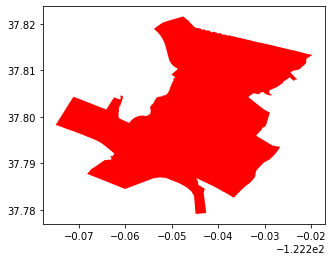

In [ ]:
# plot the tracts and district for row 140
import matplotlib.pyplot as plt

# read in csv file in geo_filename
geo_filename = 'geodata\\' + key_rows.at[94, 'geo_filename']
geo = pd.read_csv(geo_filename)

# read in csv file in tract_filename
tract_filename = 'tracts\\' + key_rows.at[94, 'tract_filename']
tract = pd.read_csv(tract_filename)

# convert geo['geometry'] to wkt
geo['geometry'] = geo['geometry'].apply(wkt.loads)
geo = gpd.GeoDataFrame(geo, geometry='geometry')

# convert tract['geometry'] to wkt
tract['geometry'] = tract['geometry'].apply(wkt.loads)
tract = gpd.GeoDataFrame(tract, geometry='geometry')

# get polygon for row['district'] in geo
district = geo[geo['district'] == key_rows.at[94, 'district']].unary_union

# plot all tracts in file
tracts = []
for index, row in tract.iterrows():
    tracts.append(row['geometry'])

# plot the tracts and district
fig, ax = plt.subplots()
geo[geo['district'] == key_rows.at[94, 'district']].plot(ax=ax, color='red')
# gpd.GeoSeries(tracts).plot(ax=ax, color='blue')
plt.show()
        